# Hippocampal Place Cells During Space Flight

This notebook demonstrates how to stream and visualize data from
[DANDI:001754](https://dandiarchive.org/dandiset/001754) — tetrode recordings of
hippocampal CA1 place cells from rats during the Neurolab Space Shuttle mission (STS-90).

**Publication:** Knierim, McNaughton & Poe (2000) "Three-dimensional spatial selectivity
of hippocampal neurons during space flight." *Nature Neuroscience* 3, 209–210.
[doi:10.1038/72910](https://doi.org/10.1038/72910)

**Contents:**
1. [Setup and data discovery](#1-setup-and-data-discovery)
2. [Load a session via streaming](#2-load-a-session-via-streaming)
3. [Explore NWB file structure](#3-explore-nwb-file-structure)
4. [Visualize position trajectories](#4-visualize-position-trajectories)
5. [Spike raster plot](#5-spike-raster-plot)
6. [Place fields: computed vs pre-computed](#6-place-fields-computed-vs-pre-computed)
7. [Compare epochs: Escher Staircase vs Magic Carpet](#7-compare-epochs)
8. [Spike positions on trajectory](#8-spike-positions-on-trajectory)

## 1. Setup and data discovery

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pynapple as nap
import remfile
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
from scipy.ndimage import gaussian_filter


def smooth_rate_map(rate_map, sigma=2):
    """Gaussian-smooth a rate map, handling NaN (unvisited) bins correctly."""
    nan_mask = np.isnan(rate_map)
    filled = np.where(nan_mask, 0, rate_map)
    occupancy = np.where(nan_mask, 0, 1.0)
    smoothed = gaussian_filter(filled, sigma=sigma)
    smooth_occ = gaussian_filter(occupancy, sigma=sigma)
    smooth_occ[smooth_occ < 0.01] = np.nan
    result = smoothed / smooth_occ
    result[nan_mask] = np.nan  # preserve original unvisited mask
    return result

nap.nap_config.suppress_conversion_warnings = True

In [2]:
# List all NWB files in the dandiset
dandiset_id = "001754"

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, "draft")
    print(f"Dandiset: {dandiset.get_raw_metadata()['name']}\n")
    assets = list(dandiset.get_assets())
    for asset in sorted(assets, key=lambda a: a.path):
        print(f"  {asset.path}  ({asset.size / 1e6:.1f} MB)")

Dandiset: Three-dimensional spatial selectivity of hippocampal neurons during space flight

  sub-Rat1/sub-Rat1_ses-19980414T125300_ecephys.nwb  (2.5 MB)
  sub-Rat1/sub-Rat1_ses-19980420T095700_behavior+ecephys.nwb  (3.6 MB)
  sub-Rat1/sub-Rat1_ses-19980425T124500_behavior+ecephys.nwb  (8.9 MB)
  sub-Rat2/sub-Rat2_ses-19980413T163700_ecephys.nwb  (2.5 MB)
  sub-Rat2/sub-Rat2_ses-19980420T095700_behavior+ecephys.nwb  (3.2 MB)
  sub-Rat2/sub-Rat2_ses-19980425T124500_behavior+ecephys.nwb  (4.3 MB)
  sub-Rat3/sub-Rat3_ses-19980414T134900_ecephys.nwb  (3.5 MB)
  sub-Rat3/sub-Rat3_ses-19980420T152800_behavior+ecephys.nwb  (4.0 MB)


The dataset contains 8 NWB files across 3 rats. Files labeled `behavior+ecephys`
contain both position tracking and spike data from in-flight recordings.
Files labeled `ecephys` only are preflight ground recordings (no position data).

We'll focus on a Flight Day 9 session from Rat 1, which has the richest data.

## 2. Load a session via streaming

In [3]:
# Stream the NWB file directly from DANDI (no download needed)
file_path = "sub-Rat1/sub-Rat1_ses-19980425T124500_behavior+ecephys.nwb"

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, "draft").get_asset_by_path(file_path)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

remote_file = remfile.File(s3_url)
h5_file = h5py.File(remote_file, "r")
io = NWBHDF5IO(file=h5_file, load_namespaces=True)
nwbfile = io.read()
print(f"Loaded: {file_path}")

Loaded: sub-Rat1/sub-Rat1_ses-19980425T124500_behavior+ecephys.nwb


## 3. Explore NWB file structure

In [4]:
# Session metadata
print(f"Session description: {nwbfile.session_description}")
print(f"Session start time:  {nwbfile.session_start_time}")
print(f"Experimenter:        {', '.join(nwbfile.experimenter)}")
print(f"Institution:         {nwbfile.institution}")
print(f"Lab:                 {nwbfile.lab}")
print(f"Publication:         {nwbfile.related_publications}")

Session description: Flight Day 9 recording — Rat 1. Escher Staircase and Magic Carpet tasks with baseline sessions.
Session start time:  1998-04-25 12:45:00+00:00
Experimenter:        Knierim, James J., McNaughton, Bruce L., Poe, Gina R.
Institution:         University of Arizona
Lab:                 McNaughton Lab
Publication:         ('doi:10.1038/72910',)


In [5]:
# Subject information
subj = nwbfile.subject
print(f"Subject ID: {subj.subject_id}")
print(f"Species:    {subj.species}")
print(f"Strain:     {subj.strain}")
print(f"Sex:        {subj.sex}")

Subject ID: Rat1
Species:    Rattus norvegicus
Strain:     Fischer 344
Sex:        M


In [6]:
# Electrode groups (tetrodes)
print("Electrode groups:")
for name, eg in sorted(nwbfile.electrode_groups.items()):
    print(f"  {name}: {eg.location}")

Electrode groups:
  TT0: hippocampal area CA1
  TT1: hippocampal area CA1
  TT10: hippocampal area CA1
  TT11: hippocampal area CA1
  TT2: hippocampal area CA1
  TT6: hippocampal area CA1
  TT8: hippocampal area CA1
  TT9: hippocampal area CA1


In [7]:
# Behavioral epochs
print("Behavioral epochs:")
epochs = nwbfile.intervals["epochs"]
for i in range(len(epochs)):
    start = epochs["start_time"][i]
    stop = epochs["stop_time"][i]
    stype = epochs["session_type"][i]
    desc = epochs["session_type_description"][i]
    duration = stop - start
    print(f"  {stype} [{start:.0f}s – {stop:.0f}s] ({duration:.0f}s): {desc}")

Behavioral epochs:
  ES [3178s – 4789s] (1611s): Escher Staircase — three-dimensional track with 90° yaw and pitch turns
  BL [4871s – 7535s] (2664s): Baseline — rectangular track
  MC [7888s – 9200s] (1312s): Magic Carpet — flat two-dimensional track
  BL [9220s – 10151s] (931s): Baseline — rectangular track


In [8]:
# Units (spike-sorted neurons)
print(f"Number of units: {len(nwbfile.units)}")
print(f"Unit columns:    {nwbfile.units.colnames}")

Number of units: 39
Unit columns:    ('tetrode', 'cluster_id', 'spike_times', 'electrodes')


## 4. Visualize position trajectories

Position was tracked with a video camera as the rat navigated the experimental tracks.
Each epoch corresponds to a different behavioral condition.

In [9]:
# Extract position data
pos_series = nwbfile.processing["behavior"]["position"]["spatial_series"]
pos_timestamps = pos_series.timestamps[:]
pos_data = pos_series.data[:]

# Build pynapple objects for position and epochs
position = nap.TsdFrame(
    t=pos_timestamps,
    d=pos_data,
    columns=["x", "y"],
)

# Build epoch IntervalSets
epoch_dict = {}
for i in range(len(epochs)):
    stype = epochs["session_type"][i]
    start = epochs["start_time"][i]
    stop = epochs["stop_time"][i]
    if stype in epoch_dict:
        # Multiple intervals with same label (e.g., two BL sessions)
        epoch_dict[stype] = epoch_dict[stype].union(nap.IntervalSet(start, stop))
    else:
        epoch_dict[stype] = nap.IntervalSet(start, stop)

print("Epochs:")
for name, ep in epoch_dict.items():
    print(f"  {name}: {len(ep)} interval(s)")

Epochs:
  ES: 1 interval(s)
  BL: 2 interval(s)
  MC: 1 interval(s)


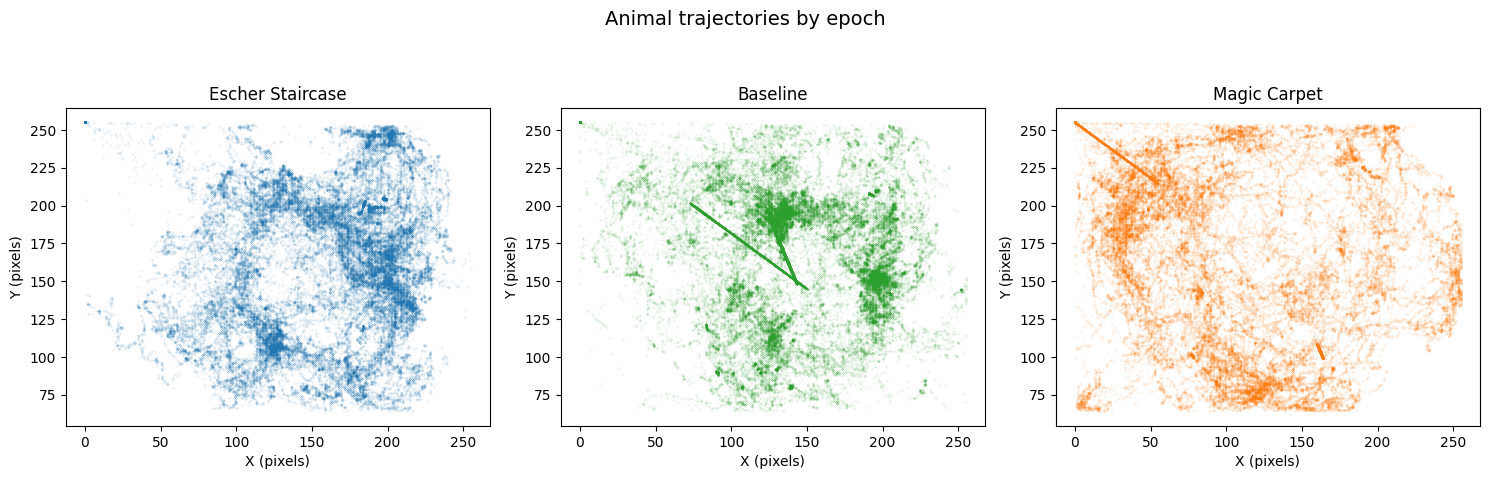

In [10]:
# Plot trajectories colored by epoch
epoch_colors = {"ES": "#1f77b4", "BL": "#2ca02c", "MC": "#ff7f0e"}
epoch_labels = {"ES": "Escher Staircase", "BL": "Baseline", "MC": "Magic Carpet"}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (epoch_name, epoch_interval) in zip(axes, epoch_dict.items()):
    pos_epoch = position.restrict(epoch_interval)
    ax.plot(
        pos_epoch["x"].values,
        pos_epoch["y"].values,
        ".",
        markersize=0.3,
        color=epoch_colors.get(epoch_name, "gray"),
        alpha=0.5,
    )
    ax.set_xlabel("X (pixels)")
    ax.set_ylabel("Y (pixels)")
    ax.set_title(epoch_labels.get(epoch_name, epoch_name))
    ax.set_aspect("equal")

fig.suptitle("Animal trajectories by epoch", fontsize=14)
fig.tight_layout()
plt.show()

The Escher Staircase track has a distinctive looping shape with yaw and pitch turns.
The Baseline is a rectangular track. The Magic Carpet is a flat 2D surface.

## 5. Spike raster plot

Each row is a different neuron. Vertical tick marks indicate spike times.

In [11]:
# Build spike TsGroup
spike_times = {}
unit_metadata = {"tetrode": [], "cluster_id": []}
for i in range(len(nwbfile.units)):
    spike_times[i] = nwbfile.units["spike_times"][i]
    unit_metadata["tetrode"].append(nwbfile.units["tetrode"][i])
    unit_metadata["cluster_id"].append(nwbfile.units["cluster_id"][i])

spikes = nap.TsGroup(spike_times)
spikes.set_info(
    tetrode=unit_metadata["tetrode"],
    cluster_id=unit_metadata["cluster_id"],
)

print(f"Loaded {len(spikes)} units")
print(f"\nFiring rates (Hz):")
print(spikes)

Loaded 39 units

Firing rates (Hz):
Index    rate     tetrode    cluster_id
-------  -------  ---------  ------------
0        0.73999  TT0        1
1        0.24322  TT0        2
2        0.09996  TT0        3
3        0.05708  TT0        4
4        0.0456   TT0        5
5        0.01391  TT0        6
6        0.03069  TT0        7
...      ...      ...        ...
32       0.10555  TT8        5
33       0.23017  TT9        1
34       0.43783  TT9        2
35       0.04517  TT9        3
36       0.5408   TT9        4
37       0.0228   TT9        5
38       0.14886  TT9        6


/var/folders/67/qdwczmzx315gj1xp7hp1f11r0000gn/T/ipykernel_12441/3838419028.py:9: UserWarning: Elements should not be passed as <class 'numpy.ndarray'>. Default time units is seconds when creating the Ts object.
  spikes = nap.TsGroup(spike_times)


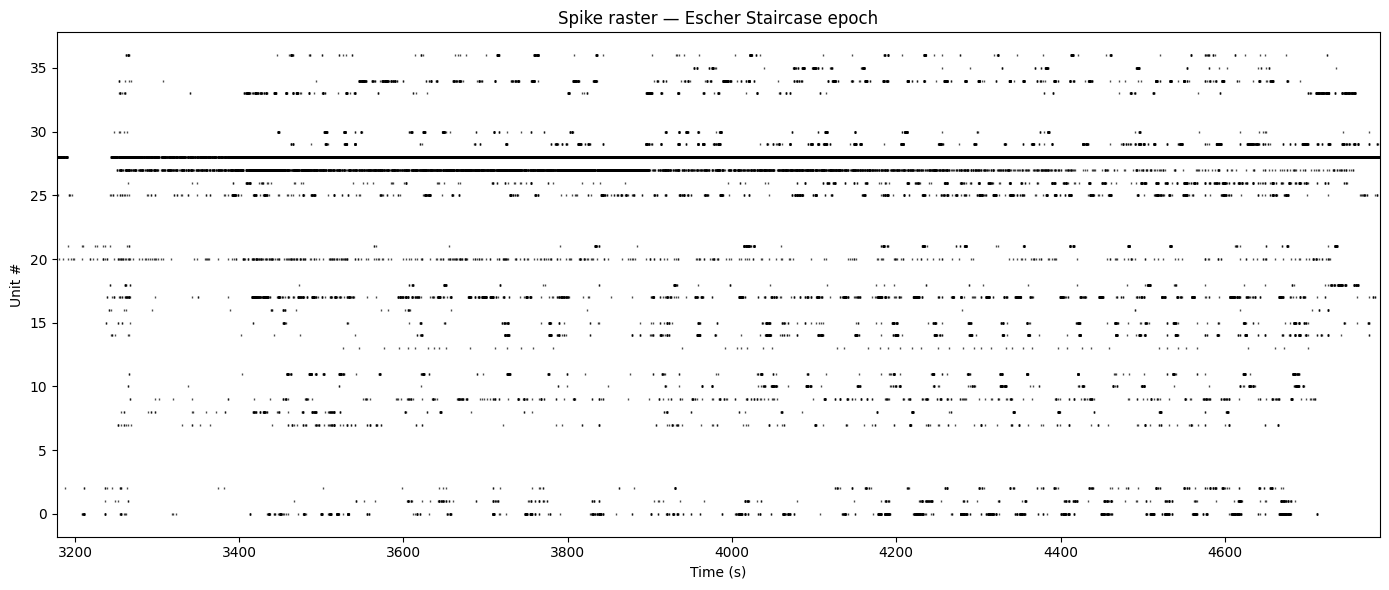

In [12]:
# Raster plot for the Escher Staircase epoch
es_epoch = epoch_dict["ES"]
spikes_es = spikes.restrict(es_epoch)

fig, ax = plt.subplots(figsize=(14, 6))
for i, (unit_id, ts) in enumerate(spikes_es.items()):
    ax.plot(ts.times(), np.full(len(ts), i), "|", markersize=1.5, color="k", alpha=0.7)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Unit #")
ax.set_title("Spike raster — Escher Staircase epoch")
ax.set_xlim(es_epoch.start[0], es_epoch.end[0])
fig.tight_layout()
plt.show()

Some units fire sparsely (putative place cells with specific spatial fields),
while a few high-rate units (e.g., units 27, 28) are likely interneurons.

## 6. Place fields: computed vs pre-computed

The NWB file stores pre-computed rate maps from the original analysis (64x64 bins,
smoothed). We can also compute place fields from the raw spike and position data
using pynapple. Below we compare the two approaches side by side for each cell.

In [13]:
# Access the pre-computed rate maps table
rm_table = nwbfile.processing["ecephys"]["rate_maps"]
print(f"Rate maps table: {len(rm_table)} entries")
print(f"Columns: {rm_table.colnames}")

# Build a lookup: (tetrode, cell_number) → pre-computed ES rate map
precomputed_es = {}
for i in range(len(rm_table)):
    if rm_table["session_type"][i] == "ES" and rm_table["cell_number"][i] > 0:
        key = (rm_table["tetrode"][i], rm_table["cell_number"][i])
        rm = rm_table["rate_map"][i].copy().astype(float)
        rm[rm < -900] = np.nan  # sentinel value for unvisited bins
        precomputed_es[key] = rm

print(f"Pre-computed ES rate maps: {len(precomputed_es)} cells")

Rate maps table: 64 entries
Columns: ('tetrode', 'source_file', 'session_type', 'cell_number', 'rate_map', 'occupancy_map')
Pre-computed ES rate maps: 23 cells


In [14]:
# Compute place fields with pynapple (64 bins) for all units during the Escher Staircase
es_epoch = epoch_dict["ES"]
pos_es = position.restrict(es_epoch)

place_fields, binsxy = nap.compute_2d_tuning_curves(
    group=spikes,
    features=pos_es,
    nb_bins=64,
    ep=es_epoch,
    minmax=(0, 255, 0, 255),
)

/Users/bdichter/miniconda3/lib/python3.12/site-packages/pynapple/process/tuning_curves.py:623: FutureWarning: compute_2d_tuning_curves is deprecated and will be removed in a future version;use compute_tuning_curves instead.
  return func(**kwargs)


In [15]:
# Match units to pre-computed maps by tetrode + cluster_id
matched = []
for uid in range(len(spikes)):
    tt = spikes.get_info("tetrode").iloc[uid]
    cl = spikes.get_info("cluster_id").iloc[uid]
    key = (tt, cl)
    if key in precomputed_es and uid in place_fields:
        matched.append((uid, tt, cl, precomputed_es[key], place_fields[uid]))

print(f"Matched cells with both pre-computed and pynapple rate maps: {len(matched)}")

Matched cells with both pre-computed and pynapple rate maps: 23


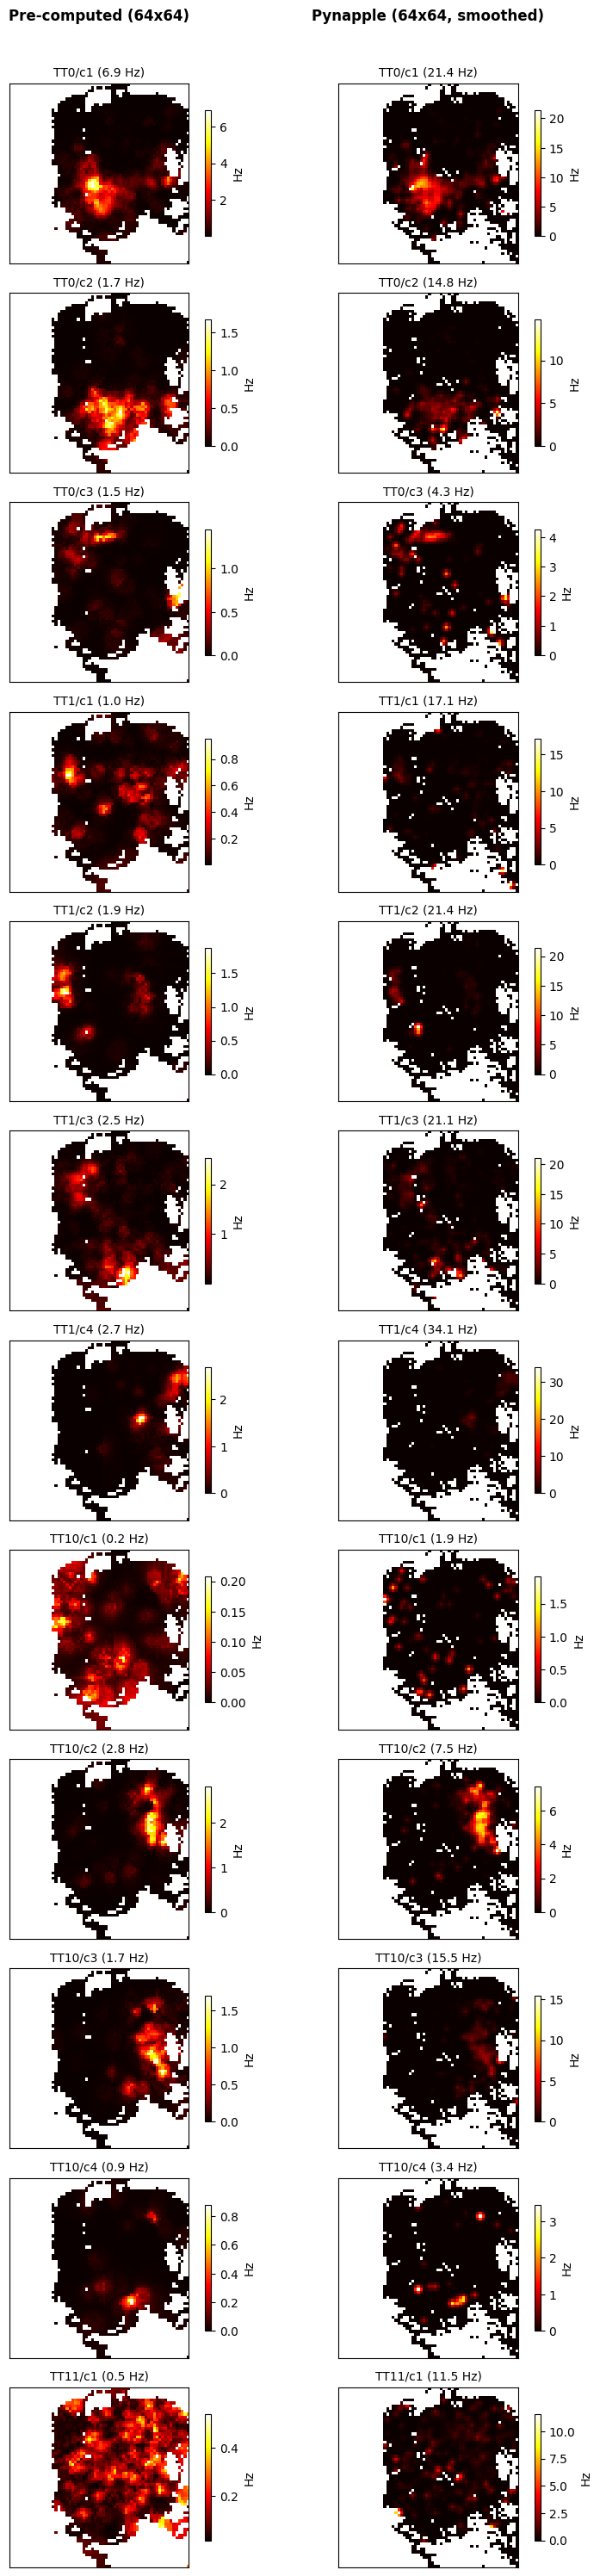

In [16]:
# Side-by-side comparison: pre-computed (left) vs pynapple (right)
n_to_show = min(12, len(matched))

fig, axes = plt.subplots(n_to_show, 2, figsize=(8, 2.5 * n_to_show + 0.8))
if n_to_show == 1:
    axes = axes.reshape(1, -1)

for idx, (uid, tt, cl, precomp, computed) in enumerate(matched[:n_to_show]):
    # Pre-computed (left)
    ax_pre = axes[idx, 0]
    im_pre = ax_pre.imshow(precomp.T, origin="lower", cmap="hot", aspect="equal")
    fig.colorbar(im_pre, ax=ax_pre, shrink=0.7, label="Hz")
    peak_pre = np.nanmax(precomp)
    ax_pre.set_title(f"{tt}/c{cl} ({peak_pre:.1f} Hz)", fontsize=10)
    ax_pre.set_xticks([])
    ax_pre.set_yticks([])

    # Pynapple-computed (right) — Gaussian smoothing (sigma=1 bin) for visualization
    smoothed = smooth_rate_map(computed, sigma=0.75)
    ax_comp = axes[idx, 1]
    im_comp = ax_comp.imshow(smoothed, origin="lower", cmap="hot", aspect="equal")
    fig.colorbar(im_comp, ax=ax_comp, shrink=0.7, label="Hz")
    peak_comp = np.nanmax(smoothed)
    ax_comp.set_title(f"{tt}/c{cl} ({peak_comp:.1f} Hz)", fontsize=10)
    ax_comp.set_xticks([])
    ax_comp.set_yticks([])

axes[0, 0].text(0.5, 1.35, "Pre-computed (64x64)", transform=axes[0, 0].transAxes,
                ha="center", fontsize=12, fontweight="bold")
axes[0, 1].text(0.5, 1.35, "Pynapple (64x64, smoothed)", transform=axes[0, 1].transAxes,
                ha="center", fontsize=12, fontweight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

The pre-computed maps (left) used the original analysis software with built-in smoothing.
The pynapple maps (right) are computed from raw spike and position data, then
Gaussian-smoothed (sigma=2 bins) for comparable visualization. The spatial firing
patterns match well — place fields appear in the same locations.

## 7. Compare epochs: Escher Staircase vs Magic Carpet

A key question in the paper is whether hippocampal place cells maintain spatial
selectivity across different track geometries in microgravity. Let's compare
place fields between the Escher Staircase (3D track) and Magic Carpet (2D flat surface).

In [17]:
# Compute place fields for the Magic Carpet epoch
mc_epoch = epoch_dict["MC"]
pos_mc = position.restrict(mc_epoch)

place_fields_mc, _ = nap.compute_2d_tuning_curves(
    group=spikes,
    features=pos_mc,
    nb_bins=64,
    ep=mc_epoch,
    minmax=(0, 255, 0, 255),
)

Units active in both epochs: 26


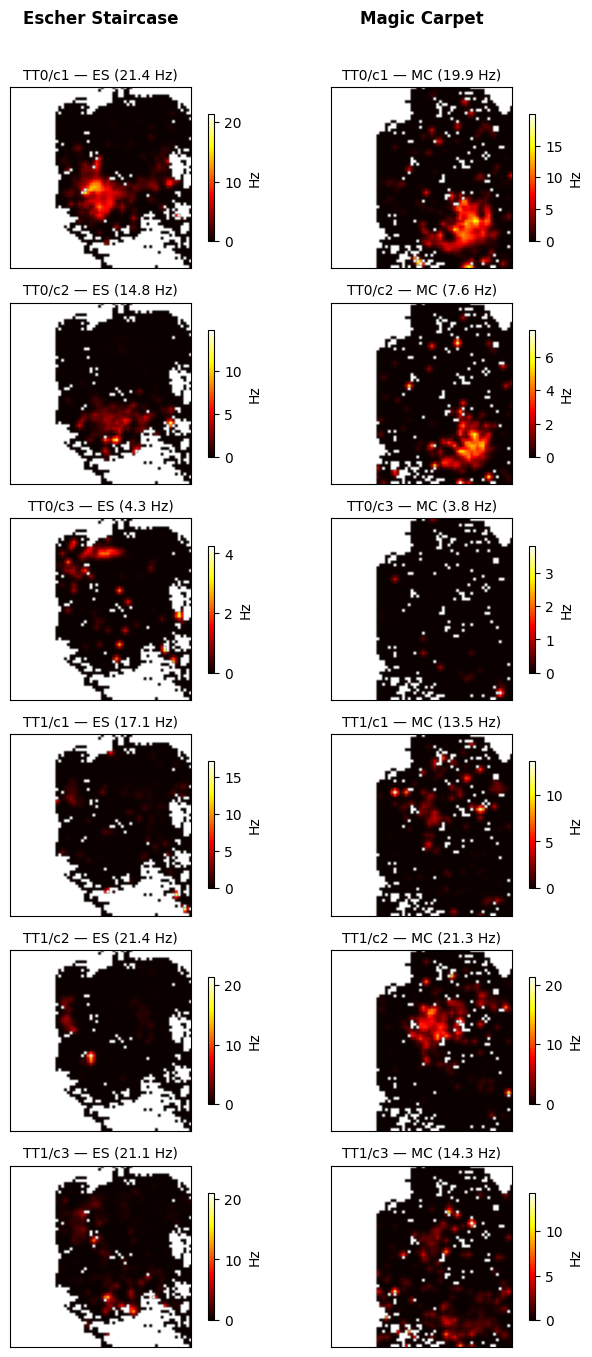

In [18]:
# Side-by-side comparison for units that are active in both epochs
# Find units active in both
active_es = {uid for uid in place_fields if np.nanmax(place_fields[uid]) > 0.5}
active_mc = {uid for uid in place_fields_mc if np.nanmax(place_fields_mc[uid]) > 0.5}
shared_units = sorted(active_es & active_mc)
print(f"Units active in both epochs: {len(shared_units)}")

n_to_show = min(6, len(shared_units))
fig, axes = plt.subplots(n_to_show, 2, figsize=(7, 2.2 * n_to_show + 0.8))
if n_to_show == 1:
    axes = axes.reshape(1, -1)

for idx, uid in enumerate(shared_units[:n_to_show]):
    # Escher Staircase
    ax_es = axes[idx, 0]
    smoothed_es = smooth_rate_map(place_fields[uid], sigma=0.75)
    im_es = ax_es.imshow(smoothed_es, origin="lower", cmap="hot", aspect="equal")
    fig.colorbar(im_es, ax=ax_es, shrink=0.7, label="Hz")
    peak_es = np.nanmax(smoothed_es)
    tt = spikes.get_info("tetrode").iloc[uid]
    cl = spikes.get_info("cluster_id").iloc[uid]
    ax_es.set_title(f"{tt}/c{cl} — ES ({peak_es:.1f} Hz)", fontsize=10)
    ax_es.set_xticks([])
    ax_es.set_yticks([])

    # Magic Carpet
    ax_mc = axes[idx, 1]
    smoothed_mc = smooth_rate_map(place_fields_mc[uid], sigma=0.75)
    im_mc = ax_mc.imshow(smoothed_mc, origin="lower", cmap="hot", aspect="equal")
    fig.colorbar(im_mc, ax=ax_mc, shrink=0.7, label="Hz")
    peak_mc = np.nanmax(smoothed_mc)
    ax_mc.set_title(f"{tt}/c{cl} — MC ({peak_mc:.1f} Hz)", fontsize=10)
    ax_mc.set_xticks([])
    ax_mc.set_yticks([])

axes[0, 0].text(0.5, 1.35, "Escher Staircase", transform=axes[0, 0].transAxes,
                ha="center", fontsize=12, fontweight="bold")
axes[0, 1].text(0.5, 1.35, "Magic Carpet", transform=axes[0, 1].transAxes,
                ha="center", fontsize=12, fontweight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

The place fields differ between the two track geometries, reflecting distinct spatial
representations for the 3D Escher Staircase and the flat Magic Carpet — consistent with
the paper's finding that hippocampal neurons maintain robust spatial selectivity even in
microgravity.

## 8. Spike positions on trajectory

Overlaying spike locations on the animal's trajectory provides an intuitive view
of where each neuron fires.

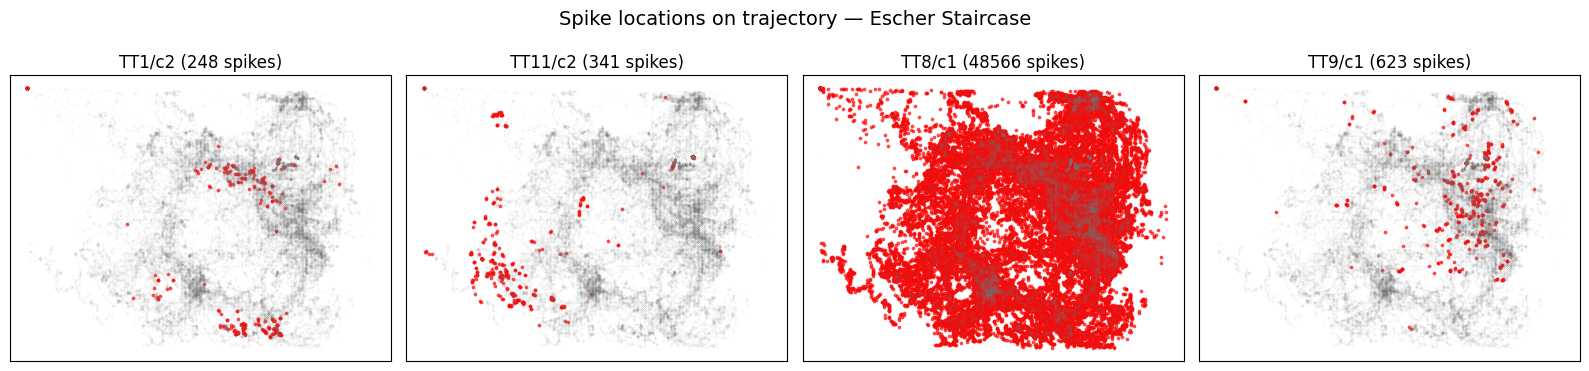

In [19]:
# Plot spike positions for a few example place cells on the Escher Staircase
# Pick the top 4 matched cells by peak rate on ES
top_cells = [uid for uid, tt, cl, _, _ in sorted(
    matched, key=lambda x: np.nanmax(x[4]), reverse=True
)][:4]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, uid in zip(axes, top_cells):
    # Trajectory
    pos_ep = position.restrict(es_epoch)
    ax.plot(pos_ep["x"].values, pos_ep["y"].values, ".", markersize=0.2,
            color="gray", alpha=0.3)

    # Spike positions: find position at each spike time
    unit_spikes = spikes[uid].restrict(es_epoch)
    spike_pos_x = pos_ep["x"].interpolate(unit_spikes)
    spike_pos_y = pos_ep["y"].interpolate(unit_spikes)

    ax.scatter(spike_pos_x.values, spike_pos_y.values, s=3, c="red", alpha=0.6)

    tt = spikes.get_info("tetrode").iloc[uid]
    cl = spikes.get_info("cluster_id").iloc[uid]
    n_spikes = len(unit_spikes)
    ax.set_title(f"{tt}/c{cl} ({n_spikes} spikes)")
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("Spike locations on trajectory — Escher Staircase", fontsize=14)
fig.tight_layout()
plt.show()

Red dots show where each neuron fired. Place cells with clear spatial fields
have spikes concentrated in specific regions of the track.

## Summary

This notebook demonstrated how to:
- **Stream NWB files** from DANDI using `remfile` (no downloads required)
- **Explore NWB structure**: metadata, electrodes, epochs, and units
- **Visualize trajectories** across behavioral conditions
- **Plot spike rasters** for all recorded neurons
- **Compute place fields** using pynapple's `compute_2d_tuning_curves`
- **Access pre-computed rate maps** stored in the NWB processing module
- **Compare spatial representations** across experimental conditions

### Resources
- [DANDI Archive](https://dandiarchive.org/dandiset/001754)
- [Knierim, McNaughton & Poe (2000)](https://doi.org/10.1038/72910)
- [PyNWB documentation](https://pynwb.readthedocs.io/)
- [Pynapple documentation](https://pynapple.org/)
- [NWB Overview](https://nwb-overview.readthedocs.io/)